Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import glob


In [5]:
!pip install Augmentor
import Augmentor

In [6]:
## mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN/CNN_assignment/Test')

In [8]:
#image counts at train and test folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [12]:
## generate train and validation dataset with 80:20 ratio.
## used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing your images to the size img_height*img_width (180*180), while writting the datasets
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    validation_split=.2,
    subset="both",
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.
Using 449 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [14]:
#calculate number of classes
num_classes = len(class_names)
num_classes

9

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

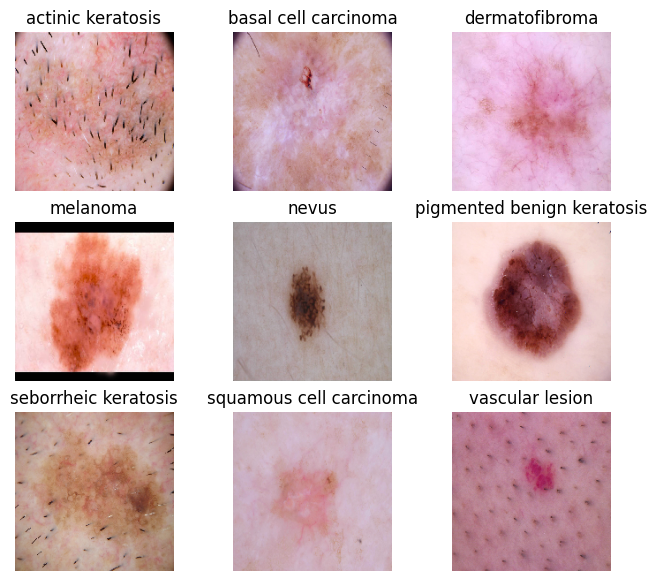

In [15]:
### visualize for each category or class name
#Dictionary to store the path of image for each class
from tensorflow.keras.preprocessing.image import load_img
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(8,7))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

plt.show()



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the initial model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
keras.utils.set_random_seed(123)
#building the initial CNN module, standardising the pixel values to [0,1] using keras preprocessing layer
#also using batch normalization for faster convergence, 25% dropout at all layers and l2 regularization used at FC layer to avoid overfitting
#2 conv layers+ 1 FC layer

model = Sequential()

#model.add(layers.Rescaling(1./255, input_shape=(180,180,3)))
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))





### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:

#using adam (accelarated gradient descent algorithm) as optimiser and entropy as loss function
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_4 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 178, 178, 32)      0         
                                                      

### Train the model

In [ ]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/20
57/57 [==============================] - 158s 606ms/step - loss: 53.0822 - accuracy: 0.2917 - val_loss: 69.3583 - val_accuracy: 0.1849
Epoch 2/20
57/57 [==============================] - 6s 98ms/step - loss: 23.7434 - accuracy: 0.3017 - val_loss: 76.3994 - val_accuracy: 0.1849
Epoch 3/20
57/57 [==============================] - 6s 98ms/step - loss: 14.8091 - accuracy: 0.4028 - val_loss: 58.3078 - val_accuracy: 0.1537
Epoch 4/20
57/57 [==============================] - 6s 99ms/step - loss: 9.1928 - accuracy: 0.4144 - val_loss: 57.3568 - val_accuracy: 0.1537
Epoch 5/20
57/57 [==============================] - 6s 98ms/step - loss: 5.9959 - accuracy: 0.4617 - val_loss: 45.0228 - val_accuracy: 0.1559
Epoch 6/20
57/57 [==============================] - 6s 98ms/step - loss: 4.1973 - accuracy: 0.4606 - val_loss: 28.5219 - val_accuracy: 0.1782
Epoch 7/20
57/57 [==============================] - 6s 99ms/step - loss: 3.2541 - accuracy: 0.4589 - val_loss: 14.4765 - val_accuracy: 0.2428


### Visualizing training results

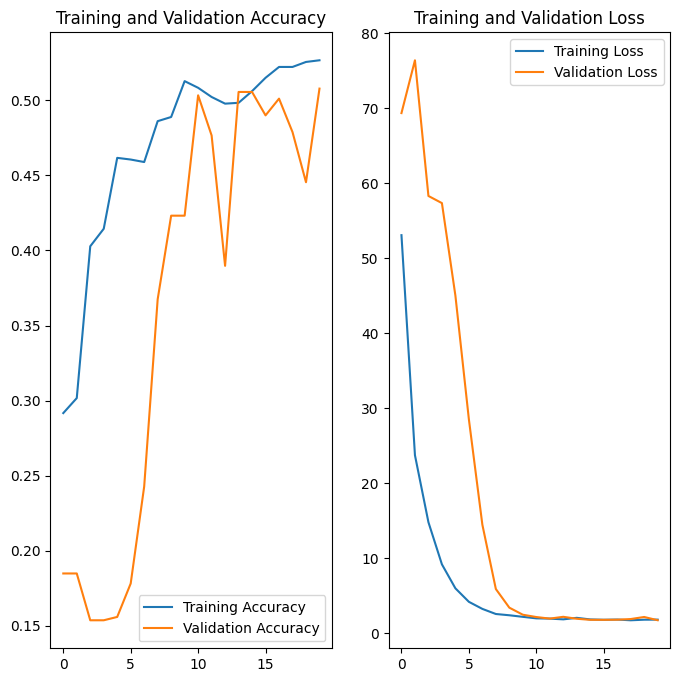

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit



### Write your findings here

From the above result, it is evident that the model is only able to achieve 52% accuracy on training dataset. This indicates that the model is not able identify many features using the current network. The validation accuracy is less being 50%, suggesting a slight overfit.
We can leverage several augmentation strategies to handle both over and underfitting by introducing more diversified features

In [17]:
# choosing different data augumentation strategies to improve model performance

data_augmentation = tf.keras.Sequential([
  layers.RandomContrast(.2, seed=123),
  layers.RandomRotation(0.2),
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)),#rescaling otherwise resulting image will be clipped whilw visualizing
  layers.RandomFlip(mode="horizontal_and_vertical", seed=123),
  layers.RandomZoom(height_factor=(0.2, 0.3), fill_mode="reflect",seed=123)

])

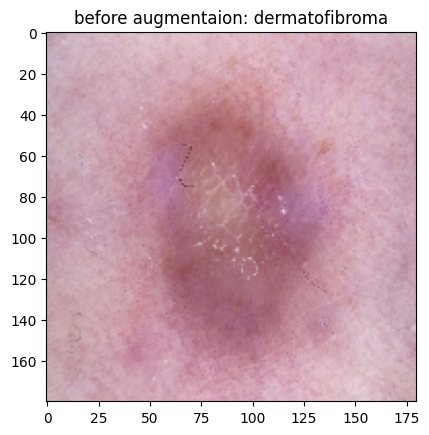

Text(0.5, 1.0, 'after augmentaion: dermatofibroma')

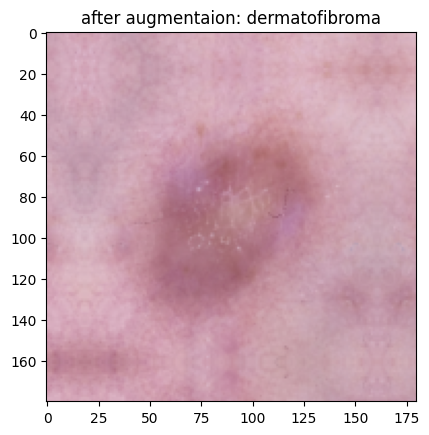

In [18]:
# visualize how the augmentation strategies works for one instance of training image.

for images, labels in val_ds.take(1):  # only take first element of dataset, validation dataset is used to save processing time
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

plt.imshow(numpy_images[0].astype("uint8"))
plt.title("before augmentaion: "+class_names[numpy_labels[0].argmax()])
plt.show()

aug_img=data_augmentation(numpy_images[0])
plt.imshow(aug_img)
plt.title("after augmentaion: " +class_names[numpy_labels[0].argmax()])

#Augmentation strategies are able to alter the image

### Todo:
### Create the model, compile and train the model


In [ ]:
#setting the seed
keras.utils.set_random_seed(123)

#building model, selecting below augmentation strategies after several trials

model = Sequential()

#model.add(layers.Rescaling(1./255, input_shape=(180,180,3)))
#model.add(layers.RandomFlip(mode="horizontal_and_vertical", seed=123))

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))
model.add(layers.RandomZoom(height_factor=(0.2, 0.3), fill_mode="reflect",seed=123, interpolation="nearest"))
model.add(layers.RandomContrast(.2, seed=123))
#model.add(layers.RandomRotation(0.2, seed=123))




model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 random_contrast_4 (RandomC  (None, 180, 180, 3)       0         
 ontrast)                                                        
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_17 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_12 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                    

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/20
57/57 [==============================] - 9s 103ms/step - loss: 50.6797 - accuracy: 0.2856 - val_loss: 53.2361 - val_accuracy: 0.1804
Epoch 2/20
57/57 [==============================] - 6s 100ms/step - loss: 21.6456 - accuracy: 0.2511 - val_loss: 58.3146 - val_accuracy: 0.1537
Epoch 3/20
57/57 [==============================] - 6s 100ms/step - loss: 13.5536 - accuracy: 0.2939 - val_loss: 67.6990 - val_accuracy: 0.1537
Epoch 4/20
57/57 [==============================] - 6s 101ms/step - loss: 8.6222 - accuracy: 0.3328 - val_loss: 55.8743 - val_accuracy: 0.1559
Epoch 5/20
57/57 [==============================] - 6s 100ms/step - loss: 5.8476 - accuracy: 0.3272 - val_loss: 33.0487 - val_accuracy: 0.1626
Epoch 6/20
57/57 [==============================] - 6s 100ms/step - loss: 4.1909 - accuracy: 0.3528 - val_loss: 30.8198 - val_accuracy: 0.1604
Epoch 7/20
57/57 [==============================] - 6s 99ms/step - loss: 3.3633 - accuracy: 0.3467 - val_loss: 13.6924 - val_accuracy: 0.24

### Visualizing the results

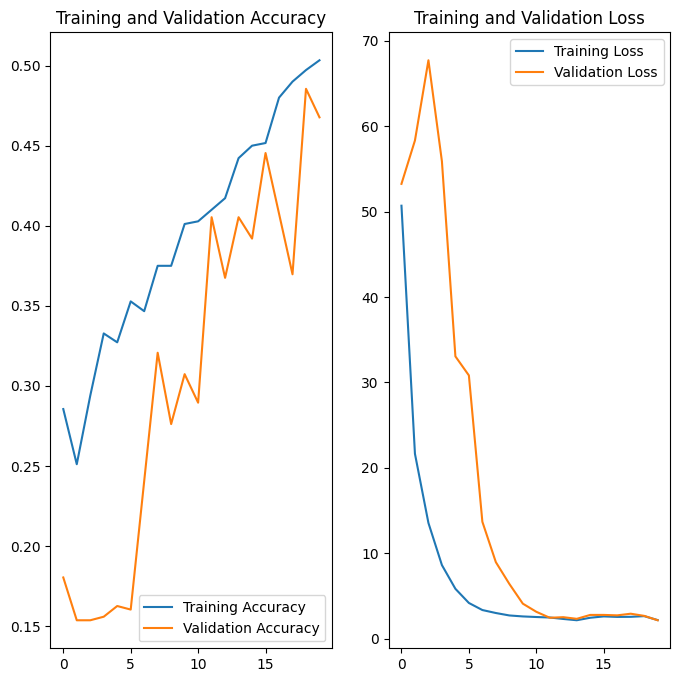

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Ans. we did not observe much difference between this model and inital model in terms of performance, the training accuracy is 50% and val accuarcy is 46%. We have also, observed that applying more layers of data augmentation is increasing the overfitting. Hence, used minimal augmentation startegies.



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## As the accuracy is not higher for previous two classification models, checking the class distribution of input data
df=pd.DataFrame()
df["class"]=pd.DataFrame(data_dir_train.glob('*/*.jpg'))
#/content/gdrive/MyDrive/CNN/CNN_assignment/Train/actinic keratosis
df["class"].apply(lambda x: str(x).split("/")[-2]).value_counts()


class
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          386
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

In [ ]:
#class imbalance is present in training data, as per above distribution

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
As per above analysis, seborrheic keratosis has least samples in
training dataset
#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis, melanoma, basal cell carcinoma and nevus are the dominating classes


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
#creating the augmented replicas of original images of each class to handle class imbalance.
path_to_training_dataset="/content/gdrive/MyDrive/CNN/CNN_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    #p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.crop_centre(probability=.1, percentage_area=0.5)
    p.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.4)
    #p.flip_top_bottom(probability=0.8)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5C0A1E07C0>: 100%|██████████| 500/500 [00:04<00:00, 105.51 Samples/s]


Initialised with 386 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=300x226 at 0x7E5C0817FB80>: 100%|██████████| 500/500 [00:06<00:00, 73.42 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5C0AC602B0>: 100%|██████████| 500/500 [00:04<00:00, 122.70 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E5BFAF52260>: 100%|██████████| 500/500 [00:08<00:00, 55.68 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=300x226 at 0x7E5BFAF85E10>: 100%|██████████| 500/500 [00:10<00:00, 46.38 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5C0AC61CC0>: 100%|██████████| 500/500 [00:04<00:00, 104.25 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E5BFAF53EE0>: 100%|██████████| 500/500 [00:04<00:00, 107.54 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5C081C1F30>: 100%|██████████| 500/500 [00:05<00:00, 96.79 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5C0A11D330>: 100%|██████████| 500/500 [00:05<00:00, 99.95 Samples/s] 


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)
#it will be 9 classes*500=4500 new augmented images

4500


In [ ]:
#store the path details for augmented images
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_fb8563de-ec59-45a2-b272-690bbfa5c52e.jpg',
 '/content/gdrive/MyDrive/CNN/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_b0261d9e-0e56-4c81-abc3-fec84bcfad76.jpg',
 '/content/gdrive/MyDrive/CNN/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_4925e20f-d3ac-4245-93ef-e3404f14e3a3.jpg',
 '/content/gdrive/MyDrive/CNN/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_76194d7f-6d59-4885-9d2a-0f908a40ccec.jpg',
 '/content/gdrive/MyDrive/CNN/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029460.jpg_2f9627fb-49cc-4695-b802-74bec327b358.jpg',
 '/content/gdrive/MyDrive/CNN/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_a92a9b93-b5a5-4e98-ba72-7385b2d17882.jpg',
 '/content/gdrive/MyDr

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*', 'output','*.jpg'))]
len(lesion_list_new)

4500

In [ ]:
#dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
!python --version
#using concat instead of append due to version

Python 3.10.12


In [ ]:
original_df=pd.DataFrame()
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df=pd.concat([original_df,df2])

In [ ]:
new_df['Label'].value_counts()
#500 augmented images have been added to each class

Label
actinic keratosis             500
pigmented benign keratosis    500
squamous cell carcinoma       500
dermatofibroma                500
seborrheic keratosis          500
basal cell carcinoma          500
nevus                         500
melanoma                      500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create training and validation datasets

In [ ]:
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Train")
train1_ds, val1_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train1,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    validation_split=.2,
    subset="both",
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123)

#initally 2249 files belonging to 9 classes, present in the directory
#it after generated 4500 augmented images, the count should ne 2249+4500=6749

Found 6749 files belonging to 9 classes.
Using 5400 files for training.
Using 1349 files for validation.


#### **Todo:** Create your model (make sure to include normalization) i.e rescaling images to normalize pixel values between (0,1)

In [ ]:
keras.utils.set_random_seed(123)
#standardising the pixel values to [0,1] using keras preprocessing layer
#also using batch normalization for faster convergence, dropouts at all layers and l2 regularization used at FC layer to avoid overfitting
#Using 3 con layers + 1 FC layer to get more abstract features

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
#using adam (accelarated gradient descent algorithm) as optimiser and entropy as loss function
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                        

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(train1_ds, validation_data=val1_ds, epochs=epochs, batch_size=batch_size, shuffle=False)

Epoch 1/30
169/169 [==============================] - 93s 471ms/step - loss: 17.2473 - accuracy: 0.2983 - val_loss: 32.3253 - val_accuracy: 0.1416
Epoch 2/30
169/169 [==============================] - 16s 93ms/step - loss: 6.1132 - accuracy: 0.3659 - val_loss: 17.5318 - val_accuracy: 0.1475
Epoch 3/30
169/169 [==============================] - 16s 91ms/step - loss: 3.6180 - accuracy: 0.3959 - val_loss: 7.1773 - val_accuracy: 0.3047
Epoch 4/30
169/169 [==============================] - 16s 93ms/step - loss: 6.3249 - accuracy: 0.3667 - val_loss: 6.4748 - val_accuracy: 0.1994
Epoch 5/30
169/169 [==============================] - 16s 90ms/step - loss: 6.4132 - accuracy: 0.3883 - val_loss: 5.0846 - val_accuracy: 0.4077
Epoch 6/30
169/169 [==============================] - 16s 91ms/step - loss: 3.7230 - accuracy: 0.4298 - val_loss: 7.9859 - val_accuracy: 0.3277
Epoch 7/30
169/169 [==============================] - 16s 93ms/step - loss: 4.0829 - accuracy: 0.4496 - val_loss: 7.0092 - val_accur

In [ ]:

#with more feature maps, accuracy is stuck at 40%
#discarded additional feature map, reinstated 3rd conv layer, increased FC layer drop out 5%, accuracy reduced to 70 %, overfit by 10%
#reinstate Fc layer drop to 25%, reduce the FC feaure maps to 256, 80% acc with huge overfit 25%
#reinstate FC layer feature map to 512, accuracy 79% overfit 9 % - best rerun val 48
#change 3rdconv layer drop to 50%, 77 acc val acc .37
#chane 2ndconv drop to 50%, 73 acc val acc 65 - rerun acc 73 val acc 51
#try 500 sample
#2ndconv drop 50 3rdconv drop 50 - accuracy: 0.7106 - val_loss: 3.0979 - val_accuracy: 0.5782
#2ndconv drop 25 3rdconv drop 25 - acc 81 % val acc 66%
#2ndconv drop 25 3rdconv drop 50 -  accuracy: 0.7820 - val_loss: 2.8103 - val_accuracy: 0.6709
#change augmentation strategies and check



#### **Todo:**  Visualize the model results

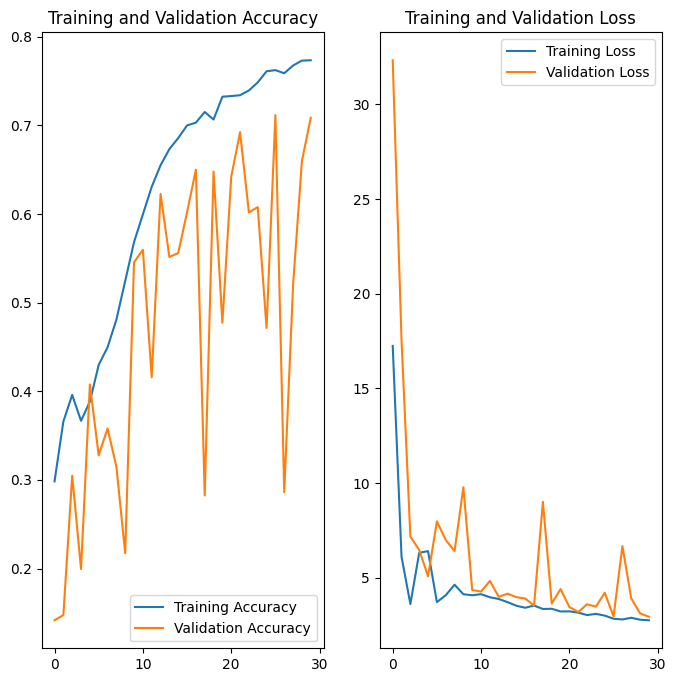

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Ans - the above model is selected after several trial and error based no combinations of feature maps, drop outs,augmented strategies, no of augmented samples although the overall model accuaracy has increased after class rebalance but it has induced overfitting to some extent (7% drop in validation accuracy). This looks like a side-effect of augmented images. The results can be improved by training the model on more non-augmented training data.

In [11]:
#Deleting the additonal additional augmented images, so that the initial model will not be impacted
#while re-runing the notebook
name=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma',
      'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
import shutil
# Specify the path of the directory to be deleted
for i in name:
      directory_path = "/content/gdrive/MyDrive/CNN/CNN_assignment/Train/"+i+"/output"
# Check if the directory exists before attempting to delete it
      if os.path.exists(directory_path):
        print(f"The directory {directory_path} has been deleted.")
        shutil.rmtree(directory_path)
      else:
        print(f"The directory {directory_path} does not exist.")

The directory /content/gdrive/MyDrive/CNN/CNN_assignment/Train/actinic keratosis/output has been deleted.
The directory /content/gdrive/MyDrive/CNN/CNN_assignment/Train/basal cell carcinoma/output has been deleted.
The directory /content/gdrive/MyDrive/CNN/CNN_assignment/Train/dermatofibroma/output has been deleted.
The directory /content/gdrive/MyDrive/CNN/CNN_assignment/Train/melanoma/output has been deleted.
The directory /content/gdrive/MyDrive/CNN/CNN_assignment/Train/nevus/output has been deleted.
The directory /content/gdrive/MyDrive/CNN/CNN_assignment/Train/pigmented benign keratosis/output has been deleted.
The directory /content/gdrive/MyDrive/CNN/CNN_assignment/Train/seborrheic keratosis/output has been deleted.
The directory /content/gdrive/MyDrive/CNN/CNN_assignment/Train/squamous cell carcinoma/output has been deleted.
The directory /content/gdrive/MyDrive/CNN/CNN_assignment/Train/vascular lesion/output has been deleted.
